In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("trees-with-species-and-dimensions-urban-forest.csv") # 19 MB
df.head()

,CoM ID,Common Name,Scientific Name,Genus,Family,Diameter Breast Height,Year Planted,Date Planted,Age Description,Useful Life Expectency,Useful Life Expectency Value,Precinct,Located in,UploadDate,CoordinateLocation,Latitude,Longitude,Easting,Northing,geolocation
0,1440992,River red gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,NaN,2009,2009-12-14,NaN,NaN,NaN,NaN,Park,2021-01-10,"-37.789042536009, 144.94750113149306",-37.789043,144.947501,319271.37,5815606.69,"-37.789042536009, 144.94750113149306"
1,1286119,River red gum,Eucalyptus camaldulensis,Eucalyptus,Myrtaceae,80.0,2008,2008-07-16,Mature,31-60 years,60.0,NaN,Park,2021-01-10,"-37.78989006812276, 144.9256959906416",-37.789890,144.925696,317353.24,5815470.25,"-37.78989006812276, 144.9256959906416"
2,1439848,European nettle tree,Celtis australis,Celtis,Cannabaceae,4.0,2009,2009-09-08,Juvenile,31-60 years,60.0,NaN,Street,2021-01-10,"-37.795227592098875, 144.91940533967247",-37.795228,144.919405,316812.46,5814865.65,"-37.795227592098875, 144.91940533967247"
3,1584631,Swamp Sheoak,Casuarina obesa,Casuarina,Casuarinaceae,NaN,2015,2015-06-18,NaN,NaN,NaN,NaN,Park,2021-01-10,"-37.795178798251044, 144.95235531785673",-37.795179,144.952355,319713.76,5814935.15,"-37.795178798251044, 144.95235531785673"
4,1286271,Golden Poplar,Populus x canadensis,Populus,Salicaceae,35.0,2008,2008-12-18,Semi-Mature,31-60 years,60.0,NaN,Street,2021-01-10,"-37.7904175404039, 144.92779056976474",-37.790418,144.927791,317538.99,5815415.81,"-37.7904175404039, 144.92779056976474"


In [5]:
df.info() # Precinct missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76928 entries, 0 to 76927
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   CoM ID                        76928 non-null  int64  
 1   Common Name                   76903 non-null  object 
 2   Scientific Name               76927 non-null  object 
 3   Genus                         76927 non-null  object 
 4   Family                        76927 non-null  object 
 5   Diameter Breast Height        24986 non-null  float64
 6   Year Planted                  76928 non-null  int64  
 7   Date Planted                  76928 non-null  object 
 8   Age Description               24969 non-null  object 
 9   Useful Life Expectency        24969 non-null  object 
 10  Useful Life Expectency Value  24969 non-null  float64
 11  Precinct                      0 non-null      float64
 12  Located in                    76926 non-null  object 
 13  U

In [6]:
df[df['CoordinateLocation'] == df['geolocation']].shape # duplicated column

(76928, 20)

In [7]:
df = df.drop(['Precinct', 'geolocation'], axis=1)
df.shape

(76928, 18)

<Axes: >

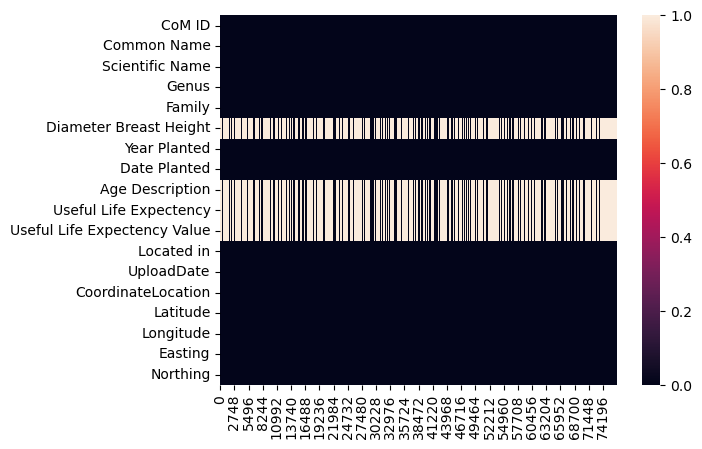

In [8]:
sns.heatmap(df.isnull().T.astype(int)) # missing values

In [9]:
df[~df.isna().any(axis=1)].shape[0] # trees with all the info (no missings)

24968

In [10]:
# A walk-through of your preliminary data-analysis, addressing
# What are other properties? (What is the date range? Is is it geo-data?, then a quick plot of locations, etc.)
# Show the fundamental distributions of the data (similar to the work we did on SF crime data)

In [11]:
import folium
from folium.plugins import MarkerCluster

map_center = [-37.820935, 144.946457] # Melbourne coords
tree_map = folium.Map(location=map_center, zoom_start=12)

marker_cluster = MarkerCluster(max_cluster_radius=100).add_to(tree_map)
df_sample = df.sample(1000) 

for i, row in df_sample.iterrows(): # TODO use whole df at the end
    folium.Marker(location=[row['Latitude'], row['Longitude']],
                  popup = folium.Popup( # TODO add more details
                      """Name: {}<br> Year planted: {}"""
                      .format(row['Common Name'], row['Year Planted']),
                      max_width=200)
).add_to(marker_cluster)

tree_map

In [32]:
import folium
from folium.plugins import TimestampedGeoJson

map_center = [-37.820935, 144.946457]  # Melbourne coords
tree_map = folium.Map(location=map_center, zoom_start=12, width=900, height=500)

# Prepare data for TimestampedGeoJson
features = []
df_sample = df[df['Year Planted'] >= 2003].sample(500)
df_sample['Year Planted'] = pd.to_datetime(df_sample['Year Planted'], format='%Y')

# Prepare data for TimestampedGeoJson
features = []
for i, row in df_sample.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['Longitude'], row['Latitude']]
        },
        'properties': {
            'time': row['Year Planted'].strftime('%Y-%m-%d'),  # Extract date
            'popup': 'Name: {}<br>Year planted: {}'.format(row['Common Name'], row['Year Planted'].strftime('%Y'))
        }
    }
    features.append(feature)

# Add TimestampedGeoJson to map
TimestampedGeoJson({
    'type': 'FeatureCollection',
    'features': features
}, period='P1Y',  # Set the time interval to 1 year
auto_play=True,  # Auto play the animation
loop=True,  # Loop the animation
max_speed=1,  # Maximum animation speed
loop_button=True,  # Show loop button for animation
date_options='YYYY',  # Date format
time_slider_drag_update=True  # Update map when dragging time slider
).add_to(tree_map)

tree_map

In [19]:
# TODO - maybe do a plot showing how many trees were 'alive' at every date (so take into account planted date
# and the life expectancy)

c:\Users\agama\miniconda3\envs\socialgraphs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Year Planted', ylabel='Count'>

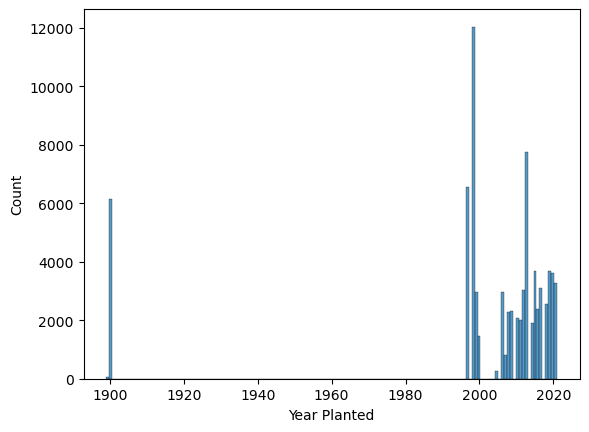

In [20]:
sns.histplot(df, x='Year Planted')

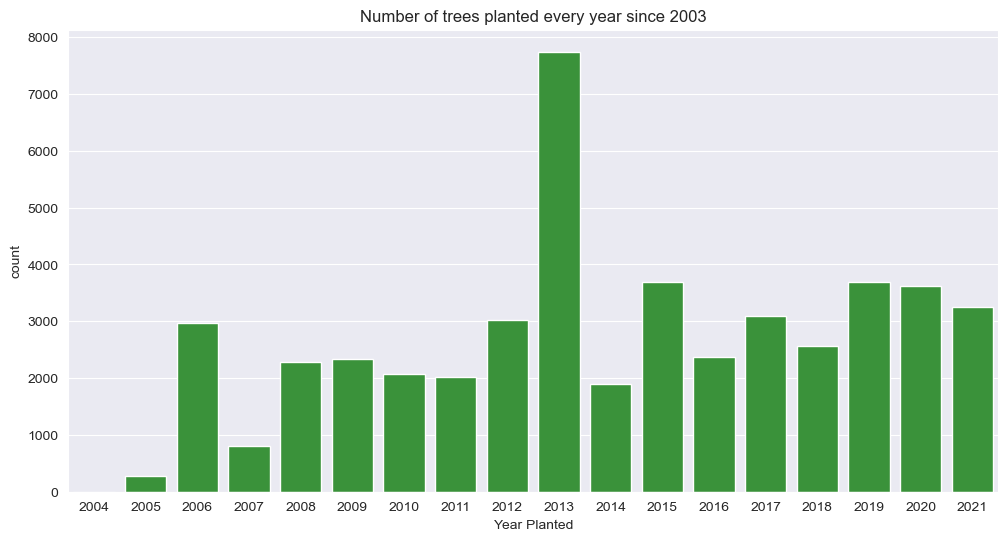

In [70]:
df_hist = df[df['Year Planted'] >= 2003].sort_values('Year Planted')
df_hist['Year Planted'] = df_hist['Year Planted'].astype(str)
plt.figure(figsize=(12,6))
sns.set_style('darkgrid')
sns.countplot(df_hist, x='Year Planted', palette=['tab:green'])
plt.title('Number of trees planted every year since 2003')
plt.show()

In [21]:
(df.Genus.value_counts().cumsum()/df.shape[0])[:20]

Genus
Eucalyptus       0.224990
Acacia           0.310225
Ulmus            0.387271
Platanus         0.461197
Corymbia         0.521826
Allocasuarina    0.571521
Casuarina        0.606580
Quercus          0.636946
Ficus            0.658083
Melaleuca        0.677101
Angophora        0.695676
Acer             0.713901
Bursaria         0.730007
Banksia          0.744995
Callistemon      0.758475
Lophostemon      0.769915
Melia            0.781172
Pyrus            0.792351
Brachychiton     0.803375
Zelkova          0.812864
Name: count, dtype: float64

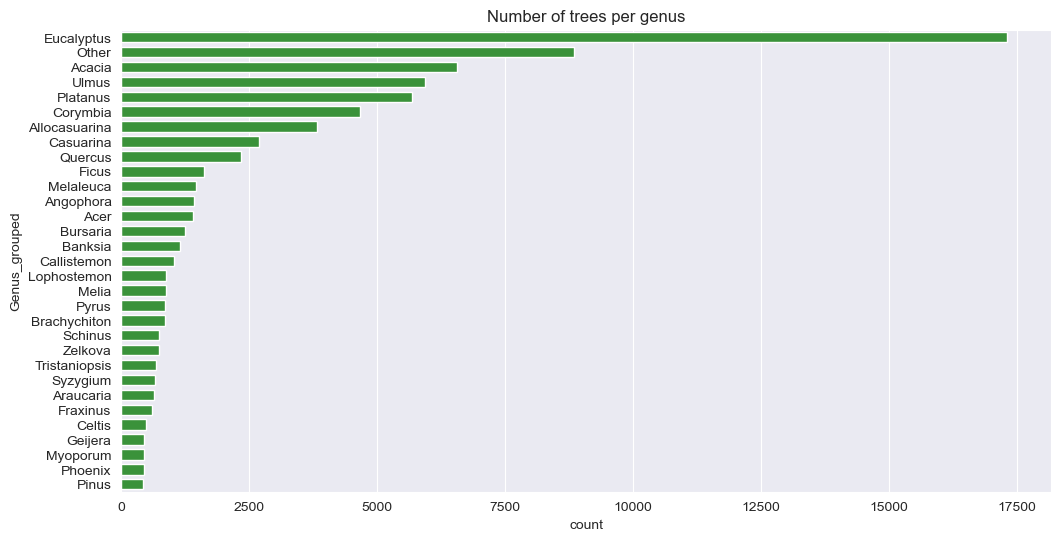

In [69]:
top_genus = df['Genus'].value_counts().head(30).index
df['Genus_grouped'] = df['Genus'].where(df['Genus'].isin(top_genus), 'Other')

genus_count = df.groupby('Genus_grouped')['CoM ID'].count().reset_index().sort_values('CoM ID', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(genus_count, x='CoM ID', y='Genus_grouped', orient='h', width=0.7, palette=['tab:green'])
plt.title('Number of trees per genus')
plt.xlabel('count')
plt.show()

In [23]:
(df.Family.value_counts().cumsum()/df.shape[0])[:20]

Family
Myrtaceae         0.370814
Fabaceae          0.463355
Ulmaceae          0.549891
Casuarinaceae     0.634645
Platanaceae       0.708572
Fagaceae          0.739042
Proteaceae        0.766080
Sapindaceae       0.789062
Moraceae          0.810368
Pittosporaceae    0.830634
Malvaceae         0.847104
Rosaceae          0.861884
Araucariaceae     0.875156
Anacardiaceae     0.887908
Meliaceae         0.899672
Arecaceae         0.910501
Pinaceae          0.919977
Oleaceae          0.929285
Cupressaceae      0.937942
Rutaceae          0.946417
Name: count, dtype: float64

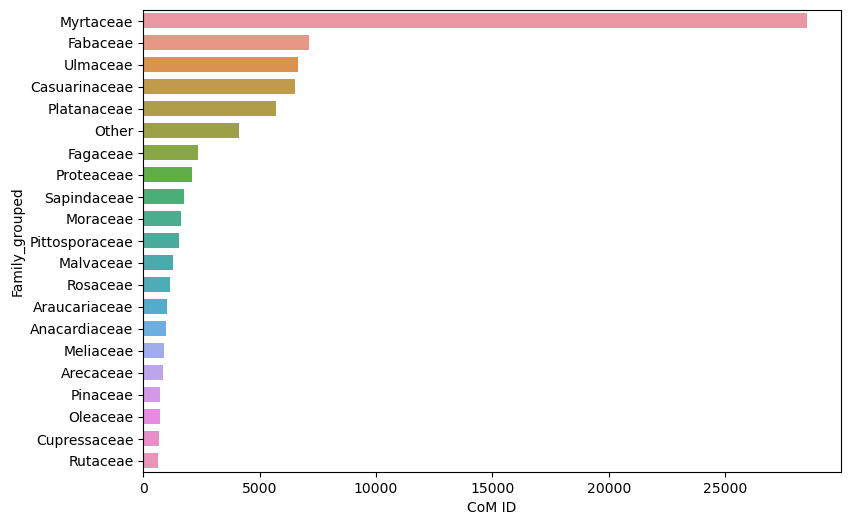

In [24]:
top_family = df['Family'].value_counts().head(20).index
df['Family_grouped'] = df['Family'].where(df['Family'].isin(top_family), 'Other')

family_count = df.groupby('Family_grouped')['CoM ID'].count().reset_index().sort_values('CoM ID', ascending=False)
plt.figure(figsize=(9,6))
sns.barplot(family_count, x='CoM ID', y='Family_grouped', orient='h', width=0.7)
plt.show()

c:\Users\agama\miniconda3\envs\socialgraphs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Useful Life Expectency Value', ylabel='Count'>

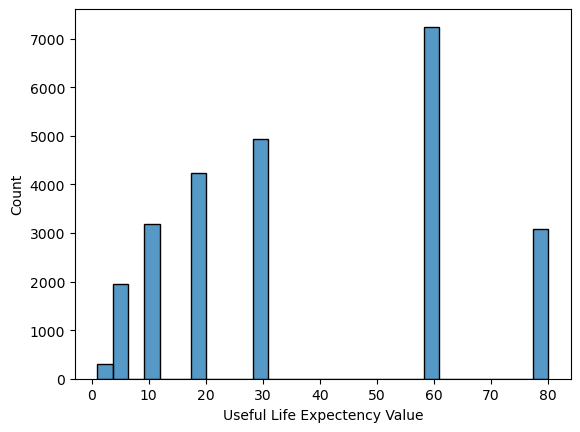

In [25]:
sns.histplot(df, x='Useful Life Expectency Value') # present only for 1/3 data

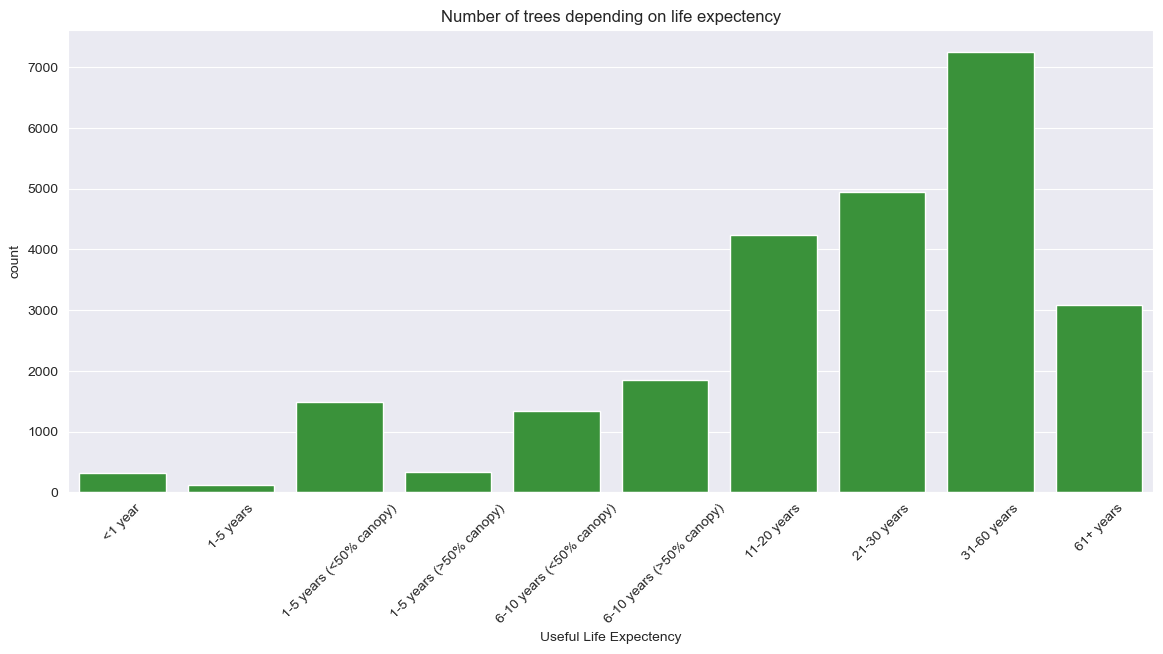

In [68]:
df_exp = df.sort_values('Useful Life Expectency Value')
plt.figure(figsize=(14,6))
sns.countplot(df_exp, x='Useful Life Expectency', palette=['tab:green']) # present only for 1/3 data
plt.xticks(rotation=45)
plt.title('Number of trees depending on life expectency')
plt.show()

<Axes: xlabel='Located in', ylabel='count'>

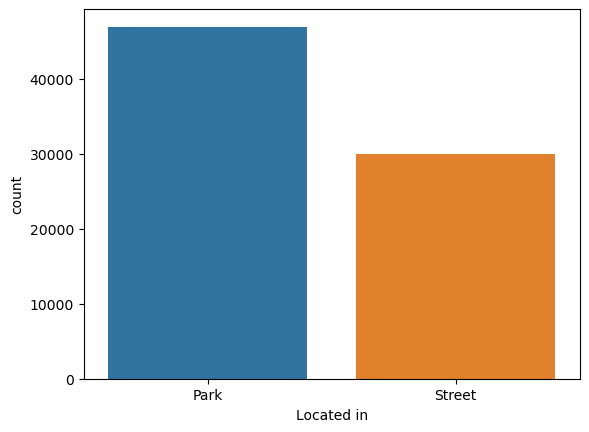

In [27]:
sns.countplot(df, x='Located in')

c:\Users\agama\miniconda3\envs\socialgraphs\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


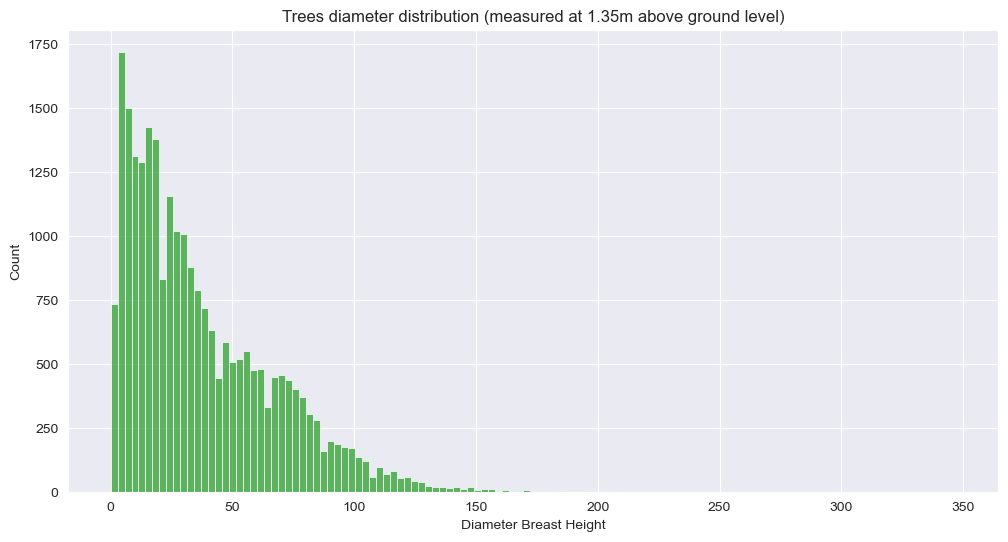

In [67]:
plt.figure(figsize=(12,6))
sns.histplot(df, x='Diameter Breast Height', color='tab:green') # present only for 1/3 data
plt.title('Trees diameter distribution (measured at 1.35m above ground level)')
plt.show()